# Predictive Modelling

## Import dependencies

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import statsmodels
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline

# A classification problem : the Adult Income dataset

Another common use case in Supervised Learning is classification. Let's try one example now with the **Adult Income** dataset. This dataset was extracted from the 1994 Census database and is described by the following variables:

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- **income**: `>50K`, `<=50K`

Prediction task is to determine whether a person makes over 50K a year.

## Recap of processing data from last week

Recap: (what did to raw data)
* one-hot encoding of variables
* etc

In [ ]:
# Upload the data 
df_raw = pd.read_csv("adult.csv", index_col=[0])

# Drop meaningless variables
df_raw = df_raw.drop(['fnlwgt'], axis=1)

# Majority of United-States occurrences HOW TO EXPLAIN THIS??
df_raw = df_raw.drop(['native.country'], axis=1)

# Scale numeric variables  - TODO: perhaps this isn't so important for DT 
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
df_raw.loc[:, numeric_cols] = scaler.fit_transform(df_raw.loc[:, numeric_cols])

# One-hot encode categorical variables 
one_hot_df = pd.get_dummies(df_raw, drop_first=True)


Let's take a look at the new table 

In [ ]:
one_hot_df.head()

In [ ]:
# Build dummy variable for working vs not working ('Without-pay')
for col in one_hot_df.columns:
    if 'workclass_' in col and ' Without-pay' not in col:
        one_hot_df = one_hot_df.drop([col], axis=1)

In [ ]:
# Remove education-num as it is difficult to interpret (and we have other columns for education levels)
one_hot_df = one_hot_df.drop(['education.num'], axis=1)

# Predictive modelling <a name="Modelling"></a>

The predictive analysis follows a descriptive stage, once we have:
 - cleaned the data
 - created a few derived variables
 - have a better understanding of the data. 
 
Its aim is to build a performing predictive model and to identify the main explanatory variables. This is an iterative process as a variety of modelling approaches are usually tested and new features are created.

The primary goal of this section is to accurately predict whether an adult is going to make more than 50K a year and understand the drivers explaining such an income.

## Exploring the data

We can look at the proportion of positive and negative labels i.e. the number of rows with income > 50K vs the number of rows where it is not. 


In [115]:
print("Number of positive labels: {}".format(one_hot_df[one_hot_df['income_>50K'] == 1].shape[0]))
print("Number of negative labels: {}".format(one_hot_df[one_hot_df['income_>50K'] == 0].shape[0]))

Number of positive labels: 7841
Number of negative labels: 24720


We have a reasonable amount of data in each class which is good. Sometimes we can have imbalanced classes, where the size of one class is much smaller than the size of the other class. In this case, we may need some additional methods to address this. See https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ for more information if you are interested. 

### Train/test split <a name="Train_test_split"></a>

A good prediction model must be generalisable - i.e., it should be able to make accurate predictions on new data. Several methods exist, to make our model more generalisable, of which the 'train/test split'.

Other methods, such as train/test/validation split and cross-validation take this approach one step further.

In [87]:
# Splitting the data into training and testing sets - a frequent test set size is 20%-30% of the original dataset

X = one_hot_df_indep.values
X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2)

### Decision tree <a name="Decision_tree"></a>

A decision tree can be perceived as a set of rules which enable to better describe and predict a given phenomenon, e.g., here, a salary `>50K` or `<= 50K`. As its name indicates, a tree is composed of branches (which link the nodes to one another or to the final leaves), nodes (in the middle of the tree) and leaves (higher end of the tree).

In our case, the tree splits at each node, on a **rule/condition** (explanatory variable and a set of values - e.g., **age > 38**) according to a criterion (Gini), to better separate `>50K` vs `<= 50K` populations.

The decision tree algorithm has several important hyperparameters (cf. below). Understanding these will enable you to avoir overfitting:

* the splitting criterion, for each node: Gini (most frequently used), entropy etc.
* the maximum depth of the tree: how many branches link the first node to the end leaves?
* the minimum sample split: the minimum number of data points in each node, after a split
* the minimum samples per leaf: the minimum number of data points in each final leaf
* the maximum number of features to consider when looking for the best split *(from the sklearn documentation)*:
    * If int, then consider max_features features at each split.
    * If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.

In [132]:
# Decision tree
# Initiate your Decision Tree Classifier model
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, 
                             min_samples_leaf=10, max_features=None)

# Fit your Decision Tree model to your train model
clf.fit(X_train, y_train)

# Predict labels on your Test set of independent variables
pred_clf = clf.predict(X_test)
# Predict probabilities on your Test set of independent variables
proba_clf = clf.predict_proba(X_test)

In [133]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, pred_clf))

Accuracy: 0.8493781667434362


We guess the labels correctly 85% of the time! But, can we think of a situation when accuracy is not a good measure of predictive power?

In [134]:
#Can also take a look at the confusion matrix, to see where our classifier is making mistakes
print(metrics.confusion_matrix(y_test, pred_clf))

[[4677  272]
 [ 709  855]]


In [153]:
# Other evaluation metrics...
print(metrics.classification_report(y_test, pred_clf))

auc = metrics.roc_auc_score(y_test, proba_clf[:,1])
print("AUC: ", auc)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4949
           1       0.76      0.55      0.64      1564

    accuracy                           0.85      6513
   macro avg       0.81      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513

AUC:  0.8906756848240802


### Feature importance

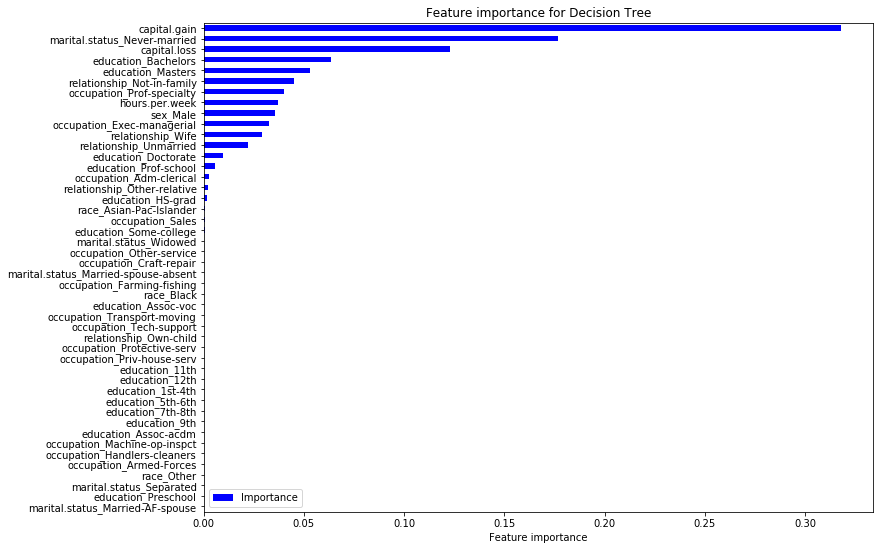

In [154]:
# Plot feature importance
features_log = pd.DataFrame(clf.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(12,9), color = 'blue')
plt.xlabel('Feature importance')
plt.title('Feature importance for Decision Tree')
plt.show()

## Advanced (aka I'm feeling smart)

#### Boosting vs bagging

* In this section, we are going to explore new types of models (random forests and XGBoost), which are globally called 'ensemble methods'. 

* The idea behind ensemble methods is to combine several models to have a better predictive performance. E.g., a single decision tree, is a weak model. If we build several decision trees on samples of the data, the final model will be more robust to outliers and will hence have a better predictive performance. 

* To understand this concept, we need to have a look at bagging and boosting, which are two sampling methods used in ensemble methods.

* **Bagging** consists in sampling with replacement. Ensemble methods using the bagging approach, build models on each sample of data; the final score of the ensemble model will be a *vote* for classification and an average for regression.

* In **Boosting**, data points all have equal weights at the beginning. These weights are increased, if the data points are misclassified (the algorithm will focus on them) and decreased, if they are well classified. 

### Random Forest <a name="Random_forest"></a>

A Random forest is an example of bagging, and consists of an ensemble of decision trees 
(built on subsets of the data, which are sampled with replacement). 
Tree nodes are split on a random subset of features. The amount of features selected is 
one of the hyperparameters of the model (max_features, here).

NB: In general, a smaller subset of variables produces less correlation and as such, a lower error rate.
There a few rules of thumb:

If M is the number of features in the dataset and m is the max number of features randomly sampled:

m << M

- for regression: m = M/3
- for classification: m = sqrt(M)

For a more advanced read on how to tune the hyperparameters of a random forest, please see https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 .

In [162]:
# Initiate the Random Forest Classifier object
clf_rf = RandomForestClassifier(random_state = 33, n_estimators=50, max_depth=5, min_samples_leaf=30, max_features=4)

In [163]:
# Fit your Random Forest to your train data
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

In [157]:
# Predict labels on your Test set of independent variables
pred_rf = clf_rf.predict(X_test)
# Predict probabilities on your Test set of independent variables
proba_rf = clf_rf.predict_proba(X_test)

In [158]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, pred_rf))

Accuracy: 0.8062336864732075


In [159]:
#Lets take a look again at the confusion matrix, to see where our classifier is making mistakes
print(metrics.confusion_matrix(y_test, pred_rf))

[[4942    7]
 [1255  309]]


In [160]:
# Other evaluation metrics...
print(metrics.classification_report(y_test, pred_rf))

auc = metrics.roc_auc_score(y_test, proba_rf[:,1])
print("AUC: ", auc)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4949
           1       0.98      0.20      0.33      1564

    accuracy                           0.81      6513
   macro avg       0.89      0.60      0.61      6513
weighted avg       0.84      0.81      0.75      6513

AUC:  0.8846070714122929


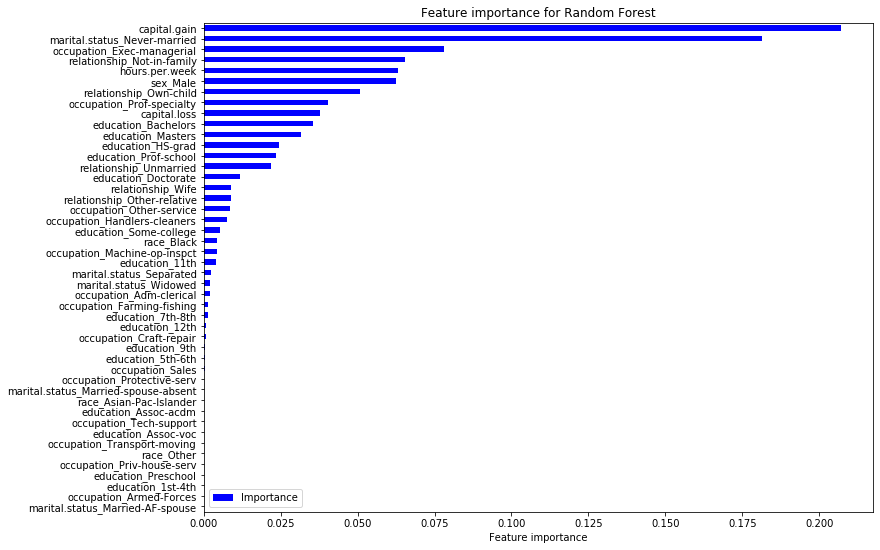

In [161]:
# Plot feature importance
features_log = pd.DataFrame(clf_rf.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(12,9), color = 'blue')
plt.xlabel('Feature importance')
plt.title('Feature importance for Random Forest')
plt.show()

## Some homework...

Some reading: 
* Imbalanced classes #TODO: add link and maybe also add a little coding task here
* Hyperparameter tuning for DT and RF in sklearn (add coding task on this as would be easy - maybe cross validation?)